__<span style="background-color:#ffffe0">第3章　時系列予測モデル構築・超入門</span>__

# 3.4　季節成分が複数ある場合の予測モデル

## 3.4.3　ARIMAXで構築する予測モデル

### 準備（必要なモジュールとデータの読み込み）

In [1]:
#
# 必要なモジュールの読み込み
#

import numpy as np
import pandas as pd

import statsmodels.api as sm

from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from pmdarima.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフのスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ設定
plt.rcParams['font.size'] = 14 #フォントサイズ

In [2]:
#
# 必要なデータセット（時系列データ）の読み込み
#

dataset = sm.datasets.get_rdataset(
    "taylor", "forecast")

print(dataset.data) #確認

          x
0     22262
1     21756
2     22247
3     22759
4     22549
...     ...
4027  27946
4028  27133
4029  25996
4030  24610
4031  23132

[4032 rows x 1 columns]


In [3]:
#
# 説明変数X（Fourier terms）の生成
#

# 空のデータフレーム生成
X = pd.DataFrame()
X.index = dataset.data.index

# Fourier termsの生成関数
def fourier_terms_gen(seasonal,terms_num):
    
    #seasonal:周期
    #terms_num:Fourier termの数（sinとcosのセット数）
    
    for num in range(terms_num):
        num = num + 1
        sin_colname = 'sin'+str(seasonal)+'_'+ str(num)
        cos_colname = 'cos'+str(seasonal)+'_'+ str(num)

        X[sin_colname] = np.sin(num * 2 * np.pi * X.index / seasonal)
        X[cos_colname] = np.cos(num * 2 * np.pi * X.index / seasonal)

# 三角関数特徴量の生成
## 336周期
fourier_terms_gen(
    seasonal=336,
    terms_num=10)

## 48周期
fourier_terms_gen(
    seasonal=48,
    terms_num=10)
    
print(X) #確認

      sin336_1  cos336_1  sin336_2  cos336_2  sin336_3  cos336_3  sin336_4  \
0     0.000000  1.000000  0.000000  1.000000  0.000000  1.000000  0.000000   
1     0.018699  0.999825  0.037391  0.999301  0.056070  0.998427  0.074730   
2     0.037391  0.999301  0.074730  0.997204  0.111964  0.993712  0.149042   
3     0.056070  0.998427  0.111964  0.993712  0.167506  0.985871  0.222521   
4     0.074730  0.997204  0.149042  0.988831  0.222521  0.974928  0.294755   
...        ...       ...       ...       ...       ...       ...       ...   
4027 -0.093364  0.995632 -0.185912  0.982566 -0.276836  0.960917 -0.365341   
4028 -0.074730  0.997204 -0.149042  0.988831 -0.222521  0.974928 -0.294755   
4029 -0.056070  0.998427 -0.111964  0.993712 -0.167506  0.985871 -0.222521   
4030 -0.037391  0.999301 -0.074730  0.997204 -0.111964  0.993712 -0.149042   
4031 -0.018699  0.999825 -0.037391  0.999301 -0.056070  0.998427 -0.074730   

      cos336_4  sin336_5  cos336_5  ...       sin48_6       cos

In [4]:
#
# データセットを学習データとテストデータ（直近7日間=30分×336）に分割
#

# データ分割
## 目的変数
y_train, y_test = train_test_split(
    dataset.data, test_size=336)

## 説明変数
X_train, X_test = train_test_split(
    X, test_size=336)

### 予測モデルの学習（学習データ利用）

In [5]:
#
# 予測モデルの学習（学習データ利用）
#

# モデル構築
arima_fourier_model = auto_arima(
    y=y_train,
    X=X_train,
    seasonal=False,
    maxiter=10)

### 予測モデルのテスト（テストデータ利用）

In [6]:
#
# 予測の実施
#

# 学習データ期間の予測値
train_pred = arima_fourier_model.predict_in_sample(
    X=X_train)

# テストデータ期間の予測値
test_pred = arima_fourier_model.predict(
    n_periods=336,
    X=X_test)

In [7]:
#
# 予測モデルのテスト（テストデータ利用）
#

print('RMSE:\n',
      np.sqrt(mean_squared_error(
          y_test, test_pred)))
print('MAE:\n',
      mean_absolute_error(
          y_test, test_pred)) 
print('MAPE:\n',
      mean_absolute_percentage_error(
          y_test, test_pred))

RMSE:
 895.0430671575112
MAE:
 664.5605339205028
MAPE:
 0.022819327950473513


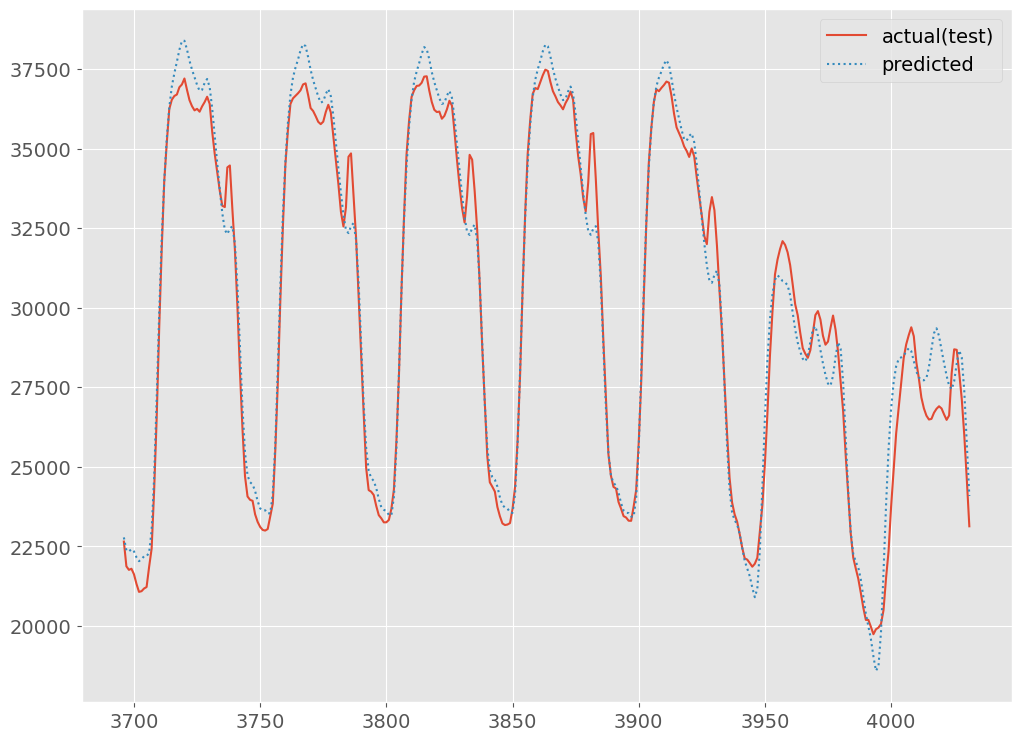

In [8]:
#
# グラフ（予測値と実測値）
#

fig, ax = plt.subplots()

# 実測値
ax.plot(
    y_test.index, 
    y_test.values, 
    linestyle='-',
    label='actual(test)')

# 予測値
ax.plot(
    y_test.index,
    test_pred, 
    linestyle=':',
    label="predicted") 

# 凡例表示
ax.legend()

plt.show()

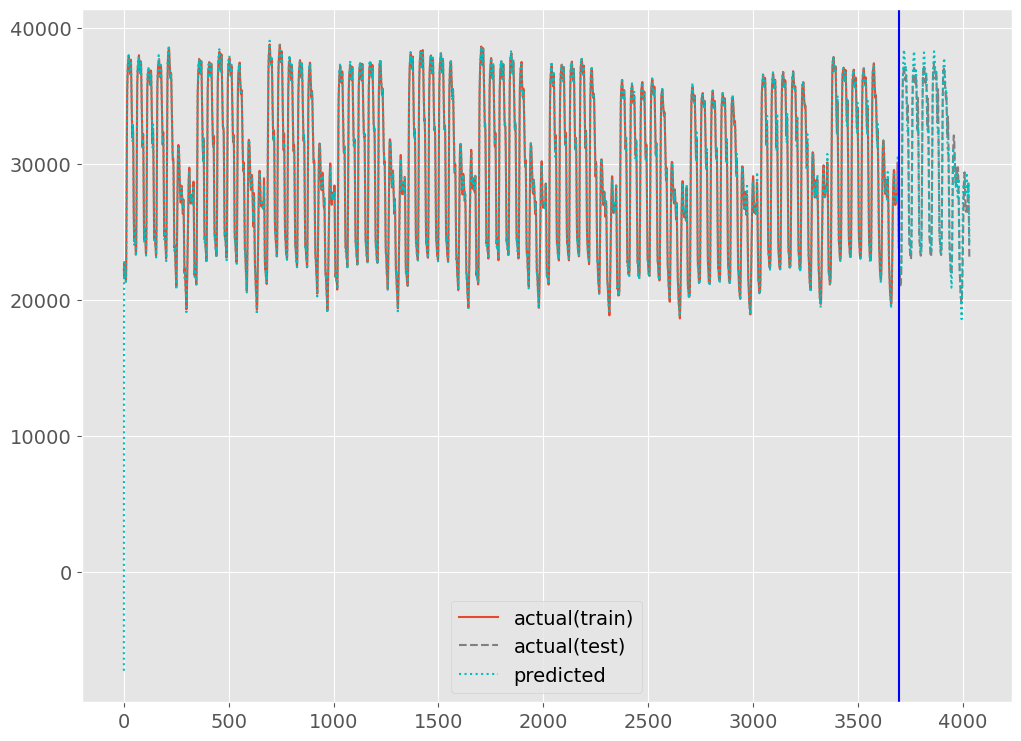

In [9]:
#
# グラフ（予測値と実測値）
#

fig, ax = plt.subplots()

# 実測値の描写
## 学習データ
ax.plot(
    y_train.index, 
    y_train.values,
    linestyle='-',
    label='actual(train)')

## テストデータ
ax.plot(
    y_test.index,
    y_test.values, 
    linestyle='--',
    label='actual(test)', 
    color='gray')

# 予測値の描写
## 学習データ
ax.plot(
    y_train.index,
    train_pred, 
    linestyle=':',
    color='c')

## テストデータ
ax.plot(
    y_test.index, 
    test_pred,
    linestyle=':',
    label="predicted",
    color='c') 

# 学習データとテスデータの間の縦線の描写
ax.axvline(
    len(y_train),
    color='blue')

# 凡例表示
ax.legend()

plt.show()